# Regular uniform designs

This example solves regular uniform designs by a quantum algorithm.
Regular uniform designs (v, b, r, k) are the designs (v columns (=elements), b rows (=blocks)) which are regular and uniform such that each block contains k elements and each element is contained in r blocks.

In [ ]:
# Initial setup for JobStorm to use Jenkins project.
# No need to run this cell after the initial setup.
from jobstorm import *
jobstorm = JobStorm("http://localhost:8080",
                    username="jenkins_run",
                    password="jenkins_run",
                    shared_dir="/home/shared",
                    project="jobstorm",
                    python_cmd="python3",
                   )
# Create a Jenkins project and a job workspace.
jobstorm.create_project()

In [1]:
from jobstorm import *
jobstorm = JobStorm(shared_dir="/home/shared", project="jobstorm", python_cmd="python3")

# import
import numpy as np

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    BasicAer,
    transpile,
)
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, QuadraticForm

# Set the above import code to JobStorm.
jobstorm.setcode()

print("Imports Successful")

/home/shared/jobstorm already exists.
Imports Successful


In [2]:
def result_top_n(result, n):
    res = [ [k, v] for k, v in result.items() ]
    res.sort(key=lambda x: x[1], reverse=True)
    k, v = zip(*res[0:min(len(result), n)])
    return dict(zip(k, v))

def print_result(result, v, b, r, k, n):
    res = [ [k, v] for k, v in result.items() ]
    res.sort(key=lambda x: x[1], reverse=True)
    p = res[n][0]
    for i in range(int(len(p)/b)):
        print(p[i*b:(i*b+b)])

In [3]:
# Apply x gate to target qubit if control_qubits[i] == 1 for any i.
def cnx(qc, cqlist, tq):
    n = len(cqlist)
    cnx_gate = XGate().control(n)
    qc.append(cnx_gate, cqlist + [tq])

# Apply x gate to target qubit if control_qubits is the binary representation of n.
def eqx(qc, cqlist, tq, n):
    bindata = bin(n)
    rblist = list(map(lambda x: int(x), bindata[2:]))
    blist = list(reversed(rblist))
    bidx = ([i for i, x in enumerate(blist) if x == 1])
    for i in range(len(cqlist)):
        if i in bidx:
            continue
        qc.x(cqlist[i])
    cnx(qc, cqlist, tq)
    for i in range(len(cqlist)):
        if i in bidx:
            continue
        qc.x(cqlist[i])

# Apply x gate to target qubit if the sum of qubits is n.
def sumeqx(qc, sumqlist, workqlist, tq, n):
    qubits = len(bin(len(sumqlist))) - 2
    tmpqlist = workqlist[0:qubits]
    qf = QuadraticForm(num_result_qubits=qubits, linear=[1]*len(sumqlist))
    qc.append(qf, sumqlist + tmpqlist)
    eqx(qc, tmpqlist, tq, n)
    qc.append(qf.inverse(), sumqlist + tmpqlist)

# Make a quantum circuit which verifies regular uniform designs.
def rud_oracle(qc, v, b, r, k):
    if b*k != v*r:
        raise ValueError("b*k != v*r")
    
    p = np.arange(v * b)
    matp = p.reshape([v, b])
    colp = matp.tolist()
    rowp = matp.transpose().tolist()
    
    n_p = len(p)
    n_col = len(colp)
    n_row = len(rowp)
    n_tmp = (len(bin(max(v, b))) - 2)
    n_req_qubits = n_p + n_col + n_row + n_tmp + 1

    n_qubits = len(qc.qubits)
    if n_req_qubits > n_qubits:
        raise ValueError(f"rud circuit need qubits > {n_req_qubits}")

    pq = list(range(0, n_p))
    colq = list(range(n_p, n_p + n_col))
    rowq = list(range(n_p + n_col, n_p + n_col + n_row))
    tmpq = list(range(n_p + n_col + n_row, n_p + n_col + n_row + n_tmp))
    tq = n_p + n_col + n_row + n_tmp
    
    for i, col in enumerate(colp):
        sumeqx(qc, list(col), tmpq, colq[i], r)
    for i, row in enumerate(rowp):
        sumeqx(qc, list(row), tmpq, rowq[i], k)
    cnx(qc, colq + rowq, tq)
    for i, col in enumerate(colp):
        sumeqx(qc, list(col), tmpq, colq[i], r)
    for i, row in enumerate(rowp):
        sumeqx(qc, list(row), tmpq, rowq[i], k)
    return pq, colq, rowq, tmpq, tq

# One step of Grover algorithm
def rud_grover_step(qc, v, b, r, k):
    pq, colq, rowq, tmpq, tq = rud_oracle(qc, v, b, r, k)
    for i in pq:
        qc.h(i)
        qc.x(i)
        if i==pq[-1]:
            qc.h(i)
    cnx(qc, pq[0:-1], pq[-1])
    for i in pq:
        qc.h(i)
        qc.x(i)
        if i==pq[-1]:
            qc.h(i)

# Grover algorithm
def rud_grover(v, b, r, k, itn):
    n_p = v * b
    n_col = v
    n_row = b
    n_tmp = (len(bin(max(v, b))) - 2)
    n_req_qubits = n_p + n_col + n_row + n_tmp + 1
    
    qc = QuantumCircuit(n_req_qubits, n_p)
    for i in range(n_p):
        qc.h(i)
    qc.x(n_req_qubits - 1)
    qc.h(n_req_qubits - 1)
    for loop in range(itn):
        rud_grover_step(qc, v, b, r, k)
    for i in range(n_p):
        qc.measure(i, i)
    return qc

In [4]:
# Solve regular uniform designs.
def rud_calc(v, b, r, k, itn):
    qc = rud_grover(v, b, r, k, itn)
    backend = BasicAer.get_backend('qasm_simulator')
    job = backend.run(transpile(qc, backend))
    result = job.result().get_counts()
    return result

In [5]:
# Set all function definitions to JobStorm.
# JobStorm outputs a function script file.
jobstorm.savefunc()

'/home/shared/jobstorm/tmp_20230709031813607901.py'

In [6]:
# Run "rud_calc" function as a job.
# JobStorm outputs a job script file.
# Be careful of large memory usage.
# v or b > 3 is not recommended.
param_vbrk = (3, 3, 1, 1)
steps = 2
jobresult = jobstorm.makefuncjob("rud_calc", *param_vbrk, steps)

In [11]:
# Check the job status.
print(jobresult.get_status())

SUCCESS


In [12]:
# Show the job list of the Jenkins project.
jobstorm.print_job_list()

  job num  timestamp            result    job script                       function script
---------  -------------------  --------  -------------------------------  ---------------------------
        5  2023/07/09 03:18:22  SUCCESS   tmp_20230709031814569038_job.py  tmp_20230709031813607901.py
        1  2023/07/05 01:18:57  SUCCESS   tmp_20230705011849040675_job.py


In [13]:
# Retrieve the result of the job.
result = jobresult.get_result()

In [14]:
# Get top 10 solutions
result10 = result_top_n(result, 10)
# print result[0]
print_result(result10, *param_vbrk, 0)

010
001
100


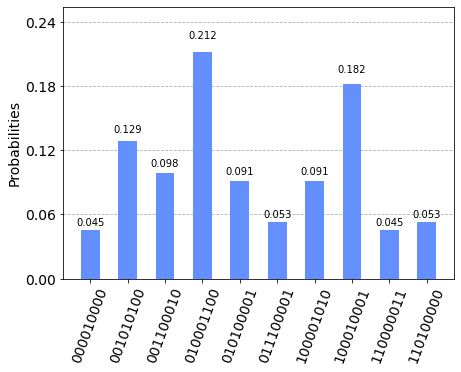

In [15]:
plot_histogram(result10)

In [16]:
jobstorm.delete_job(5)

/home/shared/jobstorm/tmp_20230709031814569038_job.py is removed.
/home/shared/jobstorm/tmp_20230709031814569038.param is removed.
/home/shared/jobstorm/tmp_20230709031814569038.param.output is removed.
/home/shared/jobstorm/tmp_20230709031813607901.py is removed.
delete build job not implemented because of jenkins request error.
